In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import datetime
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MSE
from tensorflow.python.data import Dataset

from deepcell import lossesdd
from deepcell import image_generators
from deepcell.utils import train_utils
from deepcell.utils import tracking_utils
from deepcell.utils.data_utils import get_data
from deepcell.utils.train_utils import rate_scheduler
from deepcell.utils.train_utils import get_callbacks


(7, 1040, 1159, 1)


/app/software/scikit-image/0.19.1-foss-2021b/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


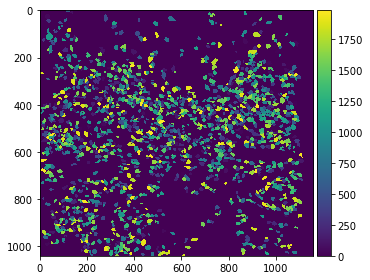

(7, 1040, 1159, 1)


In [8]:
# Import images
import glob
from skimage import io
from matplotlib import pyplot as plt
%matplotlib inline

imgfiles = glob.glob('*_img.png')
img=io.imread(imgfiles[0])
(img.shape)
im=img[:,:,0]
#io.imshow(im)
#plt.show()

imgs = [io.imread(imgfile)[:,:,0] for imgfile in imgfiles]
(imgs[0].shape)

X_train = tf.stack(imgs)
X_train = np.expand_dims(X_train, axis=-1)
print(X_train.shape)

# read mask files

maskfiles = glob.glob('*_masks.png')
img=io.imread(maskfiles[0])
(img.shape)
im=img
io.imshow(im)
plt.show()

masks = [io.imread(imgfile) for imgfile in maskfiles]
(masks[0].shape)

y_train = tf.stack(masks)
y_train = np.expand_dims(y_train, axis=-1)
print(y_train.shape)

#
X=X_train
y=y_train
np.savez("K_training_data", X=X, y=y) # objects to save need to be key value pairs

#y_train = cv2.imread('/home/shan/kdata/M872956_Position8_CD3-BUV395_no_inputs_GTmasks_1908_masks.png', cv2.IMREAD_UNCHANGED)
#y_train = y_train.reshape((1, y_train.shape[0], y_train.shape[1], 1))


In [9]:
test_size=.2
seed=0
train_dict, test_dict = get_data("K_training_data.npz", test_size=test_size, seed=seed)

In [21]:
# copied from deepcell/training.py
window_size=(224, 224)
if train_dict['X'].ndim == 4:
    DataGenerator = image_generators.SampleDataGenerator
    window_size = window_size if window_size else (30, 30)
elif train_dict['X'].ndim == 5:
    DataGenerator = image_generators.SampleMovieDataGenerator
    window_size = window_size if window_size else (30, 30, 3)
else:
    raise ValueError('Expected `X` to have ndim 4 or 5. Got',
                     train_dict['X'].ndim)
    
rotation_range=180
shear_range=0
zoom_range=(0.7, 1/0.7)
horizontal_flip=True
vertical_flip=True
datagen = DataGenerator(
        rotation_range=rotation_range,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip)
datagen_val = DataGenerator(
        rotation_range=0,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=0,
        vertical_flip=0)